<a href="https://colab.research.google.com/github/rerebebeccacca/20210602-machine-learing/blob/main/transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import zipfile
fn = "/content/drive/MyDrive/train.zip"
zf = zipfile.ZipFile(fn)
zf.extractall()#解壓縮

25000
(499, 333)


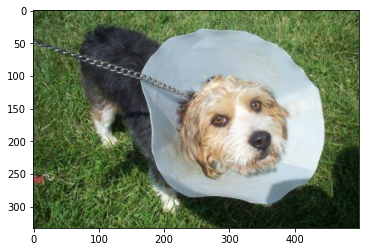

In [19]:
import glob#抓取資料文件路徑
import matplotlib.pyplot as plt
from PIL import Image#開啟照片
fns = glob.glob("./train/*")
print(len(fns))
img = Image.open(fns[0])
print(img.size)
plt.imshow(img )

In [25]:
#list的乘法複習
[1,2]*2

[1, 2, 1, 2]

In [27]:
import pandas as pd
dogf = glob.glob("train/dog.*")
catf = glob.glob("train/cat.*")
data = pd.DataFrame({
    "path":dogf + catf,
    "target":[0] * len(dogf)+ [1]* len(catf)
})
data#印出來

,path,target
0,train/dog.10694.jpg,0
1,train/dog.4214.jpg,0
2,train/dog.1140.jpg,0
3,train/dog.7814.jpg,0
4,train/dog.456.jpg,0
...,...,...
24995,train/cat.7656.jpg,1
24996,train/cat.2840.jpg,1
24997,train/cat.9132.jpg,1
24998,train/cat.5773.jpg,1


In [29]:
#%tensorflow_version 1.x#如果要用tf,且特別選tensorflow第一版（第二版就不用打後面數字）
#第一種方式：
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
vgg = VGG16(include_top=False, input_shape=(244,244,3))
tl = GlobalAveragePooling2D()(vgg.output)
out = Dense(2,activation="softmax")(tl)#如果只有兩種選1，2的話就是兩個神經元輸出
model = Model(inputs=vgg.input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0     

In [41]:
#第二種方式：
from tensorflow.keras.layers import BatchNormalization#標準化
vgg = VGG16(include_top=False, input_shape=(244,244,3))
# trainable 設定一定要在compile之前
for l in  vgg.layers:
  l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2,activation="softmax"),         
]
model = Sequential(vgg.layers + layers)#sequential是一層疊一層
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 61, 61, 256)     

In [50]:
#compile:分類器和 loss function 後面那些要 串在一起，串在一起 才可以反向傳播 觀察 要怎麼調
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

In [43]:
'''小複習：
def test():
  for i in range(10):
    yield i **2 #每次都回傳
for a in test():
  print(a)
'''

0
1
4
9
16
25
36
49
64
81


In [51]:
'''np array補充'''
test = np.random.randint(0,255,size=(3,32,32,3))
#np.array[第一個軸我要哪些筆資料,第二個軸我要哪幾個資料]參考：https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html
#參考：https://numpy.org/doc/stable/reference/arrays.nditer.html#modifying-array-values
print(test.shape)
print(test[0:2].shape)
print(test[0:2,0:28,0:28,0:2].shape)
print(test[:,:,:,0:2].shape)
print(test[...,0:2].shape)


(3, 32, 32, 3)
(2, 32, 32, 3)
(2, 28, 28, 2)
(3, 32, 32, 2)
(3, 32, 32, 2)


In [52]:
import numpy as np
# 圖片如何處理: 不是除255.0, 請always使用你偷來的模型同樣處理方式
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(fns[0]).convert("RGB").resize((224, 224))
img_np = np.array(img)
preprocess_input(img_np)

array([[[ -38.939003 ,   -2.7789993,  -31.68     ],
        [ -71.939    ,  -35.779    ,  -64.68     ],
        [ -49.939003 ,  -15.778999 ,  -44.68     ],
        ...,
        [ -18.939003 ,   10.221001 ,  -16.68     ],
        [ -51.939003 ,  -22.779    ,  -49.68     ],
        [ -53.939003 ,  -20.779    ,  -53.68     ]],

       [[ -67.939    ,  -31.779    ,  -60.68     ],
        [ -75.939    ,  -40.779    ,  -69.68     ],
        [ -53.939003 ,  -19.779    ,  -48.68     ],
        ...,
        [ -41.939003 ,   -9.778999 ,  -37.68     ],
        [ -50.939003 ,  -18.779    ,  -46.68     ],
        [ -42.939003 ,   -8.778999 ,  -41.68     ]],

       [[ -69.939    ,  -33.779    ,  -62.68     ],
        [ -64.939    ,  -29.779    ,  -58.68     ],
        [ -28.939003 ,    5.2210007,  -23.68     ],
        ...,
        [ -58.939003 ,  -21.779    ,  -50.68     ],
        [ -37.939003 ,   -3.7789993,  -32.68     ],
        [ -14.939003 ,   20.221    ,  -12.68     ]],

       ...,

      

In [53]:
# 我們無法使用fit, 1. fit_generator 2.train_on_batch/test_on_batch
# random.randint(0, 2(inclusive)): 0,1,2
# np.random,randint(0, 3(exclusive)): 0,1,2
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), size=batch)
    xidx, yidx = x[idx], y[idx]
    img_ori, img_pre, ans = [], [], []
    for xi, yi in zip(xidx, yidx):
        img = Image.open(xi).convert("RGB").resize((224, 224))
        img_np = np.array(img)
        img_p = preprocess_input(img_np)
        img_ori.append(img_np)
        img_pre.append(img_p)
        ans.append(yi)
    return np.array(img_ori), np.array(img_pre), np.array(ans)

In [54]:
from sklearn.model_selection import train_test_split
x, y = np.array(data["path"]), np.array(data["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
# batch = 25000
img_ori, img_pre, ans = get_data(x_train, y_train)
print(img_ori.shape)
print(img_pre.shape)
print(ans.shape)

(20, 224, 224, 3)
(20, 224, 224, 3)
(20,)


In [58]:
for i in range(100):
    print("-" * 15, i, "-" * 15)
    img_ori, img_p, ans = get_data(x_train, y_train)
    result = model.train_on_batch(img_p, ans)
    print("train:", result)
    img_ori, img_p, ans = get_data(x_test, y_test)
    result = model.test_on_batch(img_p, ans)
    print("validate:", result)

--------------- 0 ---------------
train: [0.3512473702430725, 0.8863636255264282]
validate: [0.21036891639232635, 0.949999988079071]
--------------- 1 ---------------
train: [0.0516444556415081, 1.0]
validate: [0.23612360656261444, 0.8999999761581421]
--------------- 2 ---------------
train: [0.06955357640981674, 0.949999988079071]
validate: [0.1305449903011322, 0.8999999761581421]
--------------- 3 ---------------
train: [0.05079991742968559, 0.949999988079071]
validate: [0.042812760919332504, 1.0]
--------------- 4 ---------------
train: [0.21565274894237518, 0.8999999761581421]
validate: [0.3414883017539978, 0.8500000238418579]
--------------- 5 ---------------
train: [0.3271881937980652, 0.8500000238418579]
validate: [0.28358596563339233, 0.949999988079071]
--------------- 6 ---------------
train: [0.005705536808818579, 1.0]
validate: [0.08372139930725098, 0.949999988079071]
--------------- 7 ---------------
train: [0.11343938112258911, 0.949999988079071]
validate: [0.0370803773403

In [59]:
# 1. 發覺loss跳動幅度太高
# 2. 發覺預測機率1.0 * e+0
# 沒有把輸入調整到合理範圍(norm)
img_ori, img_p, ans = get_data(x_test, y_test, batch=200)
pre = model.predict(img_p)
# Model沒有predict_classes可以用, 以後好像也要移除predict_classes
classes = pre.argmax(axis=1)
model.evaluate(img_p, ans)

7/7 [==============================] - 1s 106ms/step - loss: 0.1679 - accuracy: 0.9750


[0.16789551079273224, 0.9750000238418579]

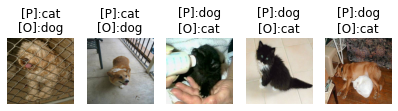

In [60]:
import numpy as np
names = ["dog", "cat"]
idx = np.nonzero(classes != ans)[0]
# np.nonzero([[0, 2, 0], [0, 0, 3]])
false_pre = classes[idx]
false_label = ans[idx] 
false_img = img_ori[idx]

plt.figure(figsize=(14, 42))
width = 10
height = len(idx) // width + 1
for i in range(len(false_img)):
    plt.subplot(height, width, i+1)
    title = "[P]:{}\n[O]:{}".format(names[false_pre[i]], names[false_label[i]])
    plt.title(title)
    plt.axis("off")
    plt.imshow(false_img[i])

輸入網址:https://i.beauty321.com/816x/https://il.beauty321.com/gallery/gallery/32675/photo-5ec25b574685c.jpg
dog 的機率: 0.894
cat 的機率: 0.106


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


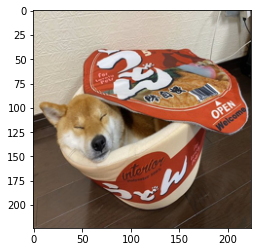

In [62]:
import requests
from PIL import Image
url = input("輸入網址:")
response = requests.get(url, verify=False, stream=True)
img = Image.open(response.raw)
img = img.resize((224, 224)).convert("RGB")
img_np = np.array(img).reshape(1, 224, 224, 3)
img_norm = preprocess_input(img_np)
pre = model.predict(img_norm)[0]
for n, p in zip(names, pre):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)